In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import imageio
import scipy as sp

from mpl_toolkits import mplot3d




from scipy.special import softmax
#np.set_printoptions(precision=1)
%matplotlib notebook
#plt.close('all')

In [2]:
def make_nodefeature(x,y,r,t):
    A=np.zeros((len(x),2))
       
    
    



def make_adjacency(x,y,r,t,ide,split_id,run):
    A=np.zeros((len(x),len(x)))
    x_id = []
    t_id = []
    for i in range(len(x)):
        x_id.append(i+1)
        t_id.append(t[i])
        for j in range(len(x)):
            if ide[i]==ide[j] and ide[i]!=-2:
                if t[i]+1==t[j] or t[i]-1==t[j]:
                    A[i,j]=1
            elif ide[i]==split_id[j]:
                if ide[i]==-1:
                    A[i,j]=1
                elif t[i]+1==t[j] or t[i]-1==t[j]:
                    A[i,j]=1
              
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'A.txt', A,fmt='%i')
    np.savetxt('./'+str(run)+'/'+'timetable.txt',np.c_[x_id,t_id], fmt='%i',delimiter='\t')
    
    return A
        

    
def make_weighted_adj_estimate(x,y,t,run):
    A=np.zeros((len(x),len(x)))
    
    for i in range(len(x)):
        for j in range(len(x)):
            A[i,0]=1.5
            if t[i]+1==t[j]: #t[i]+1==t[j] or
                A[i,j]=gaus2d(x[j], y[j], x[i], y[i]) #1/((x[i]-x[j])**2+(y[i]-y[j])**2)
            #if i>j:
                #A[i,j]=0
        if np.sum(A[i,:])!=0:
            A[i,:]=mean_normal(A[i,:])
        #print(A[i,:],i)
       
    A=A.round(decimals=2)
    
    np.savetxt('./'+str(run)+'/'+'B.txt', A)
    return A
    
    
def make_dist_matrix(x,y,t,run):
    A=np.zeros((len(x),len(x)))
    
    for i in range(len(x)):
        for j in range(len(x)):
            if t[i]+1==t[j]: #t[i]+1==t[j] or
                A[i,j]=np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
       
    
    
    np.savetxt('./'+str(run)+'/'+'D.txt', A)
    return A


def make_weighted_edgelist(A,run):
    
    e1=[]
    e2=[]
    w=[]
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j and j!=0:
                A[i,j]=0
            
            if A[i,j]!=0:
                e1.append(int(i+1))
                e2.append(int(j+1))
                w.append(A[i,j]*100)
    
    
    np.savetxt('./node2vec/graph/'+str(run)+'.edgelist', np.c_[e1,e2,w], fmt='%i',delimiter='\t')
    return A,e1,e2,w



def make_true_edgelist(A,run):
    
    e1=[]
    e2=[]
    w=[]
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
            
            if A[i,j]!=0:
                e1.append(int(i+1))
                e2.append(int(j+1))
                #w.append(A[i,j])
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'A.edgelist', np.c_[e1,e2], fmt='%i',delimiter='\t')
    return 0


def mean_normal(x):
    s=np.sum(x)
    return x/s


def gaus2d(x, y, mx, my, sx=0.07, sy=0.07):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))



def padding(maxlen,run):
    #A,B,E
    
    B=np.loadtxt('./'+str(run)+'/'+'B.txt')
    A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
    E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
                B[i,j]=0
                
    np.savetxt('./'+str(run)+'_GT'+'/'+'A_padded.txt', A,fmt='%i')
    #A=np.zeros((4,4))
    #B=np.zeros((4,4))
    
   #E=np.ones((4,6))
    
    h=np.ones(maxlen)*-1
    v=np.ones(len(A[0]))*-1
    
    #
    cur_E=len(E)
    cur_A=len(A)
    cur_Ah=len(A[0])
    zero_line=np.zeros(len(E[0]))
    for i in range(maxlen-cur_E):
        E=np.vstack([E, zero_line])
        
    for j in range(maxlen-cur_A):
        A=np.vstack([A, v])
        B=np.vstack([B, v])
        
    for z in range(maxlen-cur_Ah):
        A=np.column_stack([A, h])
        B=np.column_stack([B, h])
        
    #np.savetxt('./'+str(run)+'_GT'+'/'+'A_padded.txt', A,fmt='%i')
    np.savetxt('./'+str(run)+'/'+'B_padded.txt', B)
    np.savetxt('./'+str(run)+'/'+'embed_padded.txt',E)
    print(A.shape)   
    return A,B,E    
    
#x = np.linspace(-5, 5)
#y = np.linspace(-5, 5)
#x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
#z = gaus2d(x, y)

#def correct(A,B,E,max_len,run):



#def A_B_dense(A,B):
    
    

In [3]:
A=np.loadtxt('./'+str(2)+'/'+'embed.txt')
#print(A)

A=np.vstack([A, np.zeros(len(A[0]))])
#A=np.append(A,np.zeros(len(A[0])))
#print(A)

print(gaus2d(1.8*0.07, 1.8*0.07, 0, 0, sx=0.07, sy=0.07))


A,B,E =padding(7,1)

print(E)

1.2720668358645384
(248, 248)
[[-0.02666349  0.14534086 -0.07894487 ... -0.10363562  0.00672791
   0.20440298]
 [ 0.3620385   0.06997301 -0.13797367 ... -0.3211908  -0.3838046
   0.48900446]
 [-0.05087504  0.12621894  0.36337525 ... -0.3794855   0.15625393
   0.5338908 ]
 ...
 [-0.17262223  0.24199171 -0.09891054 ... -0.04797119 -0.1955398
   0.00079058]
 [-0.09794258  0.056402   -0.14621222 ... -0.08929877 -0.06104395
   0.24956436]
 [ 0.02848174  0.11575997  0.00362131 ... -0.25925818 -0.27713516
   0.42043668]]


In [4]:
lenA=[]
for i in range(1,15):

    run=i

    x,y,r,ide,split_id,split_prob,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5,6), unpack=True)
    #print(len(x))
    A=make_adjacency(x,y,r,t,ide,split_id,run)
    print(len(A),i)
    lenA.append(len(A))
    
    B=make_weighted_adj_estimate(x,y,t,run)
    #print(B)
    C,e1,e2,w=make_weighted_edgelist(B,run)
    make_true_edgelist(A,run)
    
    make_dist_matrix(x,y,t,run)
    
maxlen=np.max(lenA)
print(maxlen)






248 1
234 2
254 3
223 4
219 5
195 6
211 7
239 8
238 9
240 10
292 11
215 12
285 13
227 14
292


In [5]:
#print(stop)

for i in range(1,15):

    run=i

    b = np.loadtxt('./node2vec/emb/'+str(run)+'.emb',skiprows=1, delimiter=' ', unpack=True)

    ind=np.argsort(b[0])

    for l in range(len(b)):
        b[l]= np.take_along_axis(b[l], ind,axis=0)  
    b=np.transpose(b)
    b=b[:,1:]
    
    #pos= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', unpack=True)
    #split_prob = pos.T[:,5]
    #split_prob = split_prob[:, np.newaxis]
    #r = pos.T[:,2]
    #r=r[:, np.newaxis]
    
    #print(b.shape,pos.shape)
    
    #b=np.append(b,r,axis=1)
    #b=np.append(b,split_prob,axis=1)
    
    #np.savetxt('./'+str(run)+'/'+'embed.txt', b)
    
    
    ##remove below if n2v is used
    
    print(len(b[0]))
    
    #p = np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', unpack=True)
    #split_prob = p.T[:,5]
    #print(len(split_prob),split_prob)
    #b = b.T[:,0:3]
    #split_prob=split_prob[:, np.newaxis]
    #print(len(b),b)
    
    #print(b.shape,split_prob.shape)
    
    #######b=np.append(b,split_prob,axis=1)
    
    #b=np.append(pos,split_prob,axis=1)
    
    
    #print(b)
    #b=np.repeat(b, 6, axis=1)
    #print(i)
    #print(b)
    
    np.savetxt('./'+str(run)+'/'+'embed.txt', b)
    padding(maxlen,run)
    

24
(292, 292)
24
(292, 292)
24
(292, 292)
24
(292, 292)
24
(292, 292)
24
(292, 292)
24
(292, 292)
24
(292, 292)
24
(292, 292)
24
(292, 292)
24
(292, 292)
24
(292, 292)
24
(292, 292)
24
(292, 292)


python ./src/main.py --input ./graph/14.edgelist --output ./emb/14.emb --dimensions 25 --walk-length 40 --num-walks 300 --window-size 30 --p 0.25 --q 4 --iter 20 --weighted

[-0.04426407  0.66253215 -0.16167937  0.83937585  0.8324893  -0.08699266
 -0.01702337  0.70140284  0.00865834  0.7596243   0.8429809   0.79810256
  0.834468    0.03993862  0.7605088   0.03276092 -0.04812871  0.66595626
  0.07594167  0.13162614  0.5958031   0.35493243  0.1441342   0.02678058
  0.398991    0.102533    0.19040462 -0.27112782 -0.4688329   0.20291679
  0.01779593 -0.1315183  -0.636291    0.17221689  0.18052462 -0.23122276
  0.16068278  0.2147676  -0.77081394 -0.86323994 -0.34834984 -0.04999624
  0.1711882   0.12480432  0.11696402 -0.7566583  -0.82338536 -0.02944814
 -0.53316253  0.06186949  0.28595337 -0.7300438  -0.655932    0.14262228
 -0.69245785 -0.6479633  -0.51398236 -0.32764593  0.25834584  0.4671909
 -0.8832186  -0.4443639  -0.24252278  0.03224247  0.43889937  0.36196876
 -0.08621687 -0.9767341  -0.16537334 -0.88367313  0.03971865  0.19058011
  0.3464414   0.32702604  0.158821   -0.9137102   0.12549163  0.28229302
 -0.65500766  0.33559737 -0.05683571 -0.8349552   0.

<IPython.core.display.Javascript object>


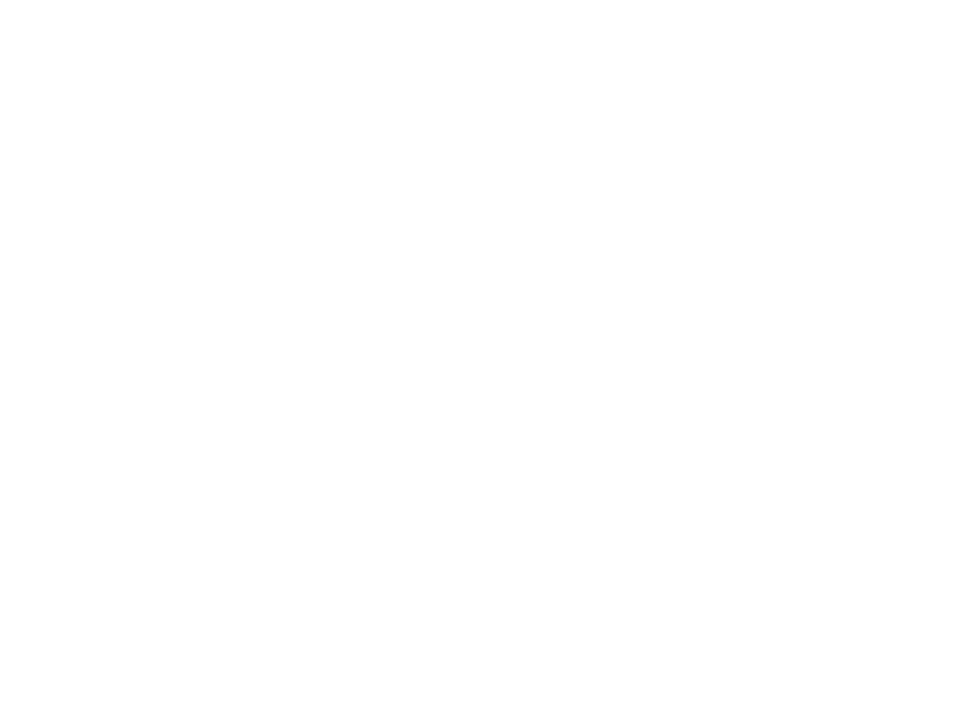

In [6]:

#np.savetxt('./node2vec/emb/'+str(10)+'.emb',i)
x,y= np.loadtxt('./'+str(2)+'/'+'embed.txt',usecols=(0,1),unpack=True)
print(x,y)
#i=ide
#print(i)
#print(i[0])
plt.scatter(x,y,s=1)
#plt.scatter(x[1],y[1],c='r')
#plt.scatter(x[i==4],y[i==4],c='blue')
#plt.scatter(x[i==5],y[i==5],c='g')
#plt.scatter(x[i==6],y[i==6],c='black')
#plt.scatter(x[i==7],y[i==7],c='violet')
#plt.scatter(x[i==10],y[i==10],c='orange')
#plt.scatter(x[i==2],y[i==2],c='grey')

<IPython.core.display.Javascript object>


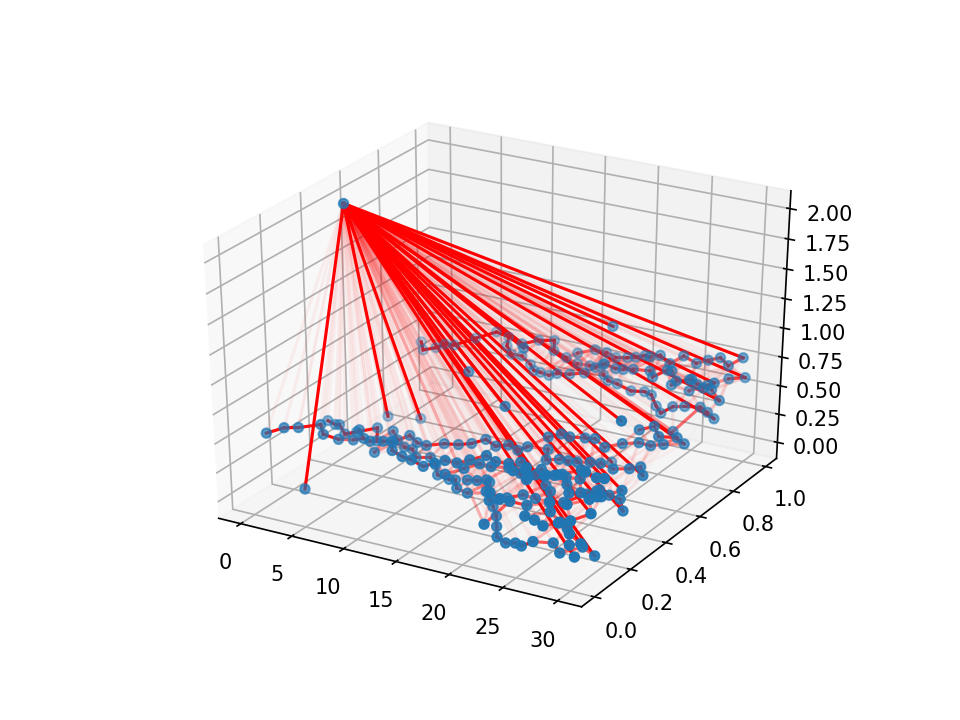

1.0 1.0
[2.0, 2.0]
2.0 1.0
[0.4846693386773547, 2.0]
2.0 5.0
[0.4846693386773547, 0.5108240838375963]
3.0 1.0
[0.44318637274549094, 2.0]
3.0 6.0
[0.44318637274549094, 0.43434801858072253]
4.0 1.0
[0.26462925851703406, 2.0]
4.0 7.0
[0.26462925851703406, 0.2655980333374415]
5.0 1.0
[0.5108240838375963, 2.0]
5.0 8.0
[0.5108240838375963, 0.5104715296496395]
6.0 1.0
[0.43434801858072253, 2.0]
6.0 11.0
[0.43434801858072253, 0.45769654284751693]
7.0 1.0
[0.2655980333374415, 2.0]
7.0 10.0
[0.2655980333374415, 0.3151733529422352]
8.0 1.0
[0.5104715296496395, 2.0]
8.0 13.0
[0.5104715296496395, 0.49217688913929697]
9.0 1.0
[0.12024048096192384, 2.0]
10.0 1.0
[0.3151733529422352, 2.0]
10.0 13.0
[0.3151733529422352, 0.49217688913929697]
10.0 14.0
[0.3151733529422352, 0.2827158825977234]
11.0 1.0
[0.45769654284751693, 2.0]
11.0 12.0
[0.45769654284751693, 0.5134633629728304]
12.0 1.0
[0.5134633629728304, 2.0]
12.0 15.0
[0.5134633629728304, 0.5269651879675996]
13.0 1.0
[0.49217688913929697, 2.0]
13.0 

100.0 108.0
[0.08697144434692318, 0.2017317917827429]
100.0 109.0
[0.08697144434692318, 0.07051771484900092]
101.0 1.0
[0.2287354417722813, 2.0]
101.0 108.0
[0.2287354417722813, 0.2017317917827429]
101.0 109.0
[0.2287354417722813, 0.07051771484900092]
101.0 114.0
[0.2287354417722813, 0.3442198887115515]
101.0 115.0
[0.2287354417722813, 0.41288370969867083]
102.0 1.0
[0.39958031023052626, 2.0]
102.0 110.0
[0.39958031023052626, 0.4439489078609872]
102.0 113.0
[0.39958031023052626, 0.33924161514533857]
102.0 115.0
[0.39958031023052626, 0.41288370969867083]
103.0 1.0
[0.5845309602907477, 2.0]
103.0 111.0
[0.5845309602907477, 0.4952632682233253]
103.0 116.0
[0.5845309602907477, 0.6213414323070346]
103.0 117.0
[0.5845309602907477, 0.6408187138385903]
104.0 1.0
[0.35609851884044486, 2.0]
104.0 108.0
[0.35609851884044486, 0.2017317917827429]
104.0 112.0
[0.35609851884044486, 0.5427158082898152]
104.0 114.0
[0.35609851884044486, 0.3442198887115515]
104.0 115.0
[0.35609851884044486, 0.4128837096

169.0 178.0
[0.2118525923999259, 0.15507315168762376]
169.0 180.0
[0.2118525923999259, 0.43501135354898784]
169.0 182.0
[0.2118525923999259, 0.30359037468069705]
169.0 188.0
[0.2118525923999259, 0.22908214010552713]
169.0 189.0
[0.2118525923999259, 0.4021735974826176]
170.0 1.0
[0.5030695243596468, 2.0]
170.0 180.0
[0.5030695243596468, 0.43501135354898784]
170.0 181.0
[0.5030695243596468, 0.5502753999001887]
170.0 182.0
[0.5030695243596468, 0.30359037468069705]
170.0 185.0
[0.5030695243596468, 0.4116805310997582]
170.0 189.0
[0.5030695243596468, 0.4021735974826176]
171.0 1.0
[0.7315727609235038, 2.0]
171.0 179.0
[0.7315727609235038, 0.6601811788182508]
171.0 184.0
[0.7315727609235038, 0.7819297875908784]
171.0 187.0
[0.7315727609235038, 0.6969120485041489]
172.0 1.0
[0.4155522351842558, 2.0]
172.0 180.0
[0.4155522351842558, 0.43501135354898784]
172.0 181.0
[0.4155522351842558, 0.5502753999001887]
172.0 182.0
[0.4155522351842558, 0.30359037468069705]
172.0 185.0
[0.4155522351842558, 0.4

231.0 246.0
[0.6265068834844917, 0.7579343092536877]
232.0 1.0
[0.5772863749797053, 2.0]
232.0 245.0
[0.5772863749797053, 0.6105322601144717]
232.0 252.0
[0.5772863749797053, 0.5015606669977837]
232.0 253.0
[0.5772863749797053, 0.39339587157807193]
232.0 254.0
[0.5772863749797053, 0.39986090057718005]
233.0 1.0
[0.396428056990734, 2.0]
233.0 247.0
[0.396428056990734, 0.3960314256687092]
233.0 250.0
[0.396428056990734, 0.41106377403961003]
233.0 251.0
[0.396428056990734, 0.5109529238254594]
233.0 254.0
[0.396428056990734, 0.39986090057718005]
234.0 1.0
[0.4493792674515106, 2.0]
234.0 247.0
[0.4493792674515106, 0.3960314256687092]
234.0 250.0
[0.4493792674515106, 0.41106377403961003]
234.0 251.0
[0.4493792674515106, 0.5109529238254594]
235.0 1.0
[0.45212012349267977, 2.0]
235.0 239.0
[0.45212012349267977, 0.4421007577873958]
235.0 243.0
[0.45212012349267977, 0.5703105849751288]
235.0 250.0
[0.45212012349267977, 0.41106377403961003]
236.0 1.0
[0.6949421125888291, 2.0]
236.0 240.0
[0.69494

In [10]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')

run=3

x,y,r,ide,split_id,split_prob,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5,6), unpack=True)



#id1,id2=np.loadtxt('./'+str(run)+'_GT'+'/'+'reconstruct.edgelist', delimiter='\t', usecols=(0,1), unpack=True)
#id1,id2=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.edgelist', delimiter='\t', usecols=(0,1), unpack=True)
id1,id2,w=np.loadtxt('./node2vec/graph/'+str(run)+'.edgelist', delimiter='\t', usecols=(0,1,2), unpack=True)
xline=[]
yline=[]
tline=[]
for i in range(len(id1)):
    
    xline=[]
    yline=[]
    tline=[]
    
    print(id1[i],id2[i])
    xline.append(x[int(id1[i]-1)])   
    yline.append(y[int(id1[i]-1)])
    tline.append(t[int(id1[i]-1)])
    
    xline.append(x[int(id2[i]-1)])
    yline.append(y[int(id2[i]-1)])
    tline.append(t[int(id2[i]-1)])
    
    print(xline)
    
    ax.plot3D(tline, yline, xline, c='red',alpha=w[i]/100)
    #ax.plot3D(tline, yline, xline, c='grey')


#zline = np.linspace(0, 15, 1000)
#xline = np.sin(zline)
#yline = np.cos(zline)
#

# Data for three-dimensional scattered points
zdata = x
xdata = t
ydata = y
ax.scatter3D(xdata, ydata, zdata);

plt.savefig('./TimeGraph.png',dpi=my_dpi,transparent=False) 

blue


<IPython.core.display.Javascript object>


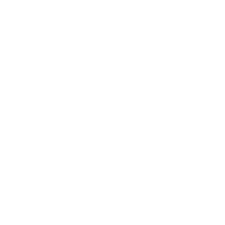

c_full ['blue', 'green', 'violet']
prev_c ['blue' 'green' 'violet']
c ['blue']


IndexError: list index out of range

In [8]:
def colour_func(ii,prev_c,prev_id,id1,id2):
    id1=id1[id2==ii]
    #print(id1,id2)
    if len(id1)==0:
        return prev_c[int(ii-1)]
    else:
        #print(id1,prev_id,prev_c)
        print('prev_c',np.array(prev_c))
        c_cf=np.array(prev_c)[prev_id==id1[0]]
        print('c',c_cf)
    return c_cf[0]
    


c=['blue','green','violet']

id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
id_f=[1,2,3]


print(c[id_f==1])


    


for t in range(31):
    
    
    my_dpi=96
    pix=150
    
    
    fig = plt.figure(figsize=(pix/my_dpi, pix/my_dpi), dpi=my_dpi)
    fig = plt.gcf()
    ax = fig.gca()
    
    print('c_full',c)
    prev_c=c
    prev_id=id_f
    
    c=[]
    id_f=[]
    
    for u in range(len(id[tt==t])):
        x_n=x[int(id[tt==t][u]-1)]  
        y_n=y[int(id[tt==t][u]-1)]
        r_n=r[int(id[tt==t][u]-1)]  
        c_cf=colour_func(id[tt==t][u],prev_c,prev_id,id1,id2)
        c.append(c_cf)
        #print('c.app',c)
        id_f.append(id[tt==t][u])
        circ1=plt.Circle((x_n,y_n), r_n, color=c_cf)
        ax.add_patch(circ1)
        
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    plt.savefig('./'+str(run)+'_GT'+'/'+str(t)+'.png',dpi=my_dpi,transparent=False) 

In [ ]:
x_t=[]
for j in range(len(ide)):
    x_t=[]
    x_t.append(x[ide==j])
    print(str(j),x_t)